# Analyze War machinery

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr
from dotenv import load_dotenv


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# from util import get_keyframe_paths

In [106]:
load_dotenv()

CHAPTERS_DATA_TSV = Path(os.getenv("CHAPTERS_DATA_TSV")).resolve()
CONTENT_CLASSIFICATIONS_DIR = Path(os.getenv("CONTENT_CLASSIFICATIONS_DIR")).resolve()
war_machinery = "war machinery"

In [107]:
def get_war_machine_ratio(row: pd.Series) -> float | None:
    filename = row["filestem"] + "_" + row["chapter"] + ".csv"
    path = CONTENT_CLASSIFICATIONS_DIR / filename
    if not path.is_file():
        return None
    try: 
        df = pd.read_csv(path)
        n = len(df)
        if n == 0:
            return None
        shots = len(df[df["prediction"] == war_machinery])
        return shots / n
    except Exception as e:
        print(e)
        return None

In [108]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
len(df)

2369

In [109]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

In [110]:
df_description = "flagged as soldier depiction scenes"
df = DF_SOLDIERS

print(f"Data size: {len(df)}")

df["war_machinery_ratio"] = df.apply(lambda row: get_war_machine_ratio(row), axis=1)

Data size: 1503


In [111]:
df = df[df["war_machinery_ratio"].notna()]

In [112]:
df["war_machinery_ratio"].describe()

count    1473.000000
mean        0.270069
std         0.243404
min         0.000000
25%         0.055556
50%         0.222222
75%         0.438356
max         1.000000
Name: war_machinery_ratio, dtype: float64

In [113]:
# Compute mean ratios per episode
episode_stats = df.groupby(['year', 'episode']).agg({
    'war_machinery_ratio': 'mean',
}).reset_index()

In [114]:
episode_stats

,year,episode,war_machinery_ratio
0,1940,511,0.206219
1,1940,512,0.214218
2,1940,513,0.230365
3,1940,515,0.121671
4,1940,517,0.347142
...,...,...,...
210,1944,744,0.271025
211,1944,745,0.244697
212,1944,746,0.181028
213,1945,747,0.213038


In [115]:
year_stats = episode_stats.groupby('year').agg({
    'war_machinery_ratio': 'mean',
}).reset_index()

In [116]:
year_stats

,year,war_machinery_ratio
0,1940,0.242562
1,1941,0.282266
2,1942,0.296017
3,1943,0.274969
4,1944,0.231736
5,1945,0.247412


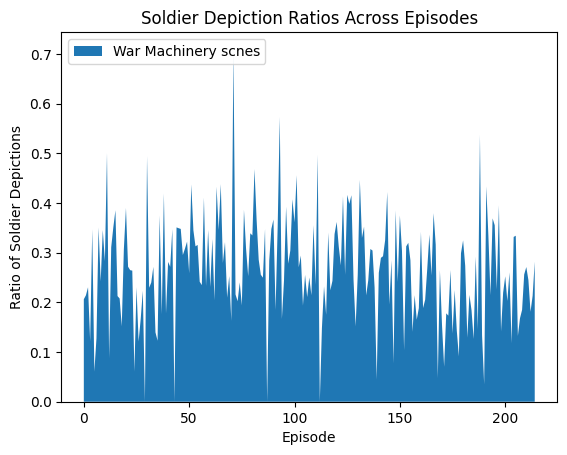

In [117]:
palette = sns.color_palette()  # 3 colors for the 3 categories
# Sort by episode if needed
episode_stats = episode_stats.sort_values(['year', 'episode'])

plt.stackplot(
    episode_stats.index,  # just a numeric index or time
    episode_stats['war_machinery_ratio'],
    labels=['War Machinery scnes'],
    colors=palette
)
plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Ratio of Soldier Depictions")
plt.title("Soldier Depiction Ratios Across Episodes")
plt.show()


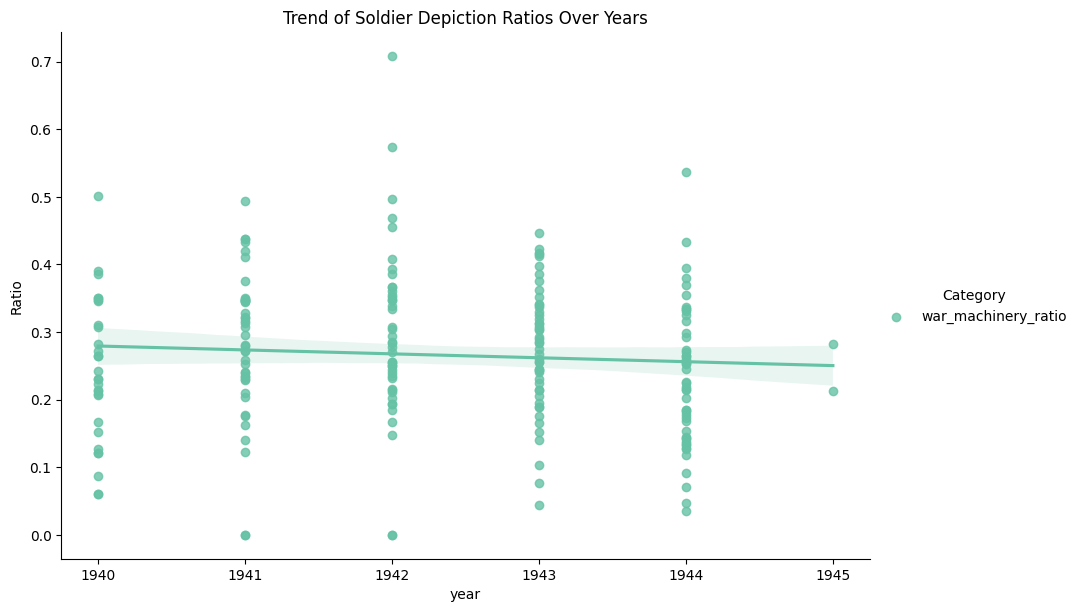

In [118]:
episode_stats_long = episode_stats.melt(
    id_vars=['year', 'episode'],
    value_vars=['war_machinery_ratio'],
    var_name='Category',
    value_name='Ratio'
)

# Plot trendlines using linear regression
sns.lmplot(
    data=episode_stats_long,
    x='year',
    y='Ratio',
    hue='Category',
    palette='Set2',
    height=6,
    aspect=1.5,
    ci=95  # 95% confidence interval
)
plt.title("Trend of Soldier Depiction Ratios Over Years")
plt.show()

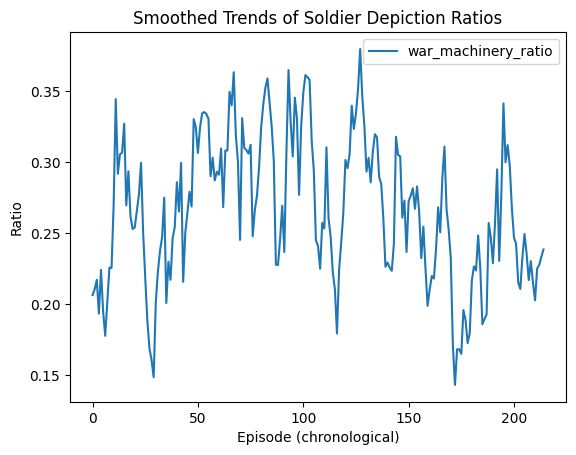

In [119]:
episode_stats_sorted = episode_stats.sort_values(['year', 'episode'])

for category, color in zip(['war_machinery_ratio'], palette):
    smoothed = episode_stats_sorted[category].rolling(window=5, min_periods=1).mean()
    plt.plot(smoothed, label=category, color=color)

plt.legend()
plt.xlabel("Episode (chronological)")
plt.ylabel("Ratio")
plt.title("Smoothed Trends of Soldier Depiction Ratios")
plt.show()
